# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.90KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

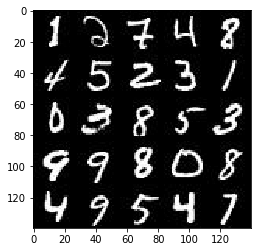

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [5]:
show_n_images = 5

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height,  image_channels), name="real_input_images")
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
    
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    # TODO: Build Model

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    tot_batches = data_shape[0] // batch_size

    steps=0

    print (data_shape)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                
                #batch images adapted to tanh
                batch_images = batch_images*2

                # Sample random noise for generator
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))

                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict= {input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict= {input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict= {input_z: batch_z, input_real: batch_images, lr: learning_rate})
               
                
                #Print out every 100 steps

                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epochs: {}/{}".format(epoch_i, epoch_count), 
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = image_channels, image_mode = data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epochs: 0/2 Discriminator Loss: 3.5688... Generator Loss: 0.0643
Epochs: 0/2 Discriminator Loss: 2.3633... Generator Loss: 0.3472
Epochs: 0/2 Discriminator Loss: 1.5757... Generator Loss: 0.4370
Epochs: 0/2 Discriminator Loss: 2.4123... Generator Loss: 0.1695
Epochs: 0/2 Discriminator Loss: 2.0335... Generator Loss: 0.2299
Epochs: 0/2 Discriminator Loss: 1.7159... Generator Loss: 0.3241
Epochs: 0/2 Discriminator Loss: 1.6119... Generator Loss: 0.3695
Epochs: 0/2 Discriminator Loss: 1.7930... Generator Loss: 0.2976
Epochs: 0/2 Discriminator Loss: 1.6481... Generator Loss: 0.3535
Epochs: 0/2 Discriminator Loss: 1.7714... Generator Loss: 0.3113


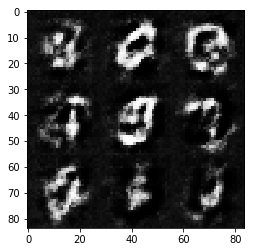

Epochs: 0/2 Discriminator Loss: 1.4404... Generator Loss: 0.4426
Epochs: 0/2 Discriminator Loss: 1.7442... Generator Loss: 0.3206
Epochs: 0/2 Discriminator Loss: 1.6418... Generator Loss: 0.3500
Epochs: 0/2 Discriminator Loss: 1.4352... Generator Loss: 0.4887
Epochs: 0/2 Discriminator Loss: 1.9416... Generator Loss: 0.2554
Epochs: 0/2 Discriminator Loss: 1.8512... Generator Loss: 0.2829
Epochs: 0/2 Discriminator Loss: 1.7321... Generator Loss: 0.3457
Epochs: 0/2 Discriminator Loss: 1.7770... Generator Loss: 0.3233
Epochs: 0/2 Discriminator Loss: 1.6680... Generator Loss: 0.3629
Epochs: 0/2 Discriminator Loss: 1.4700... Generator Loss: 0.4974


Epochs: 0/2 Discriminator Loss: 1.9334... Generator Loss: 0.2663
Epochs: 0/2 Discriminator Loss: 1.5321... Generator Loss: 0.4938
Epochs: 0/2 Discriminator Loss: 1.8232... Generator Loss: 0.3612
Epochs: 0/2 Discriminator Loss: 2.0460... Generator Loss: 0.2296
Epochs: 0/2 Discriminator Loss: 1.8726... Generator Loss: 0.2784
Epochs: 0/2 Discriminator Loss: 1.8381... Generator Loss: 0.2839
Epochs: 0/2 Discriminator Loss: 2.0058... Generator Loss: 0.2586
Epochs: 0/2 Discriminator Loss: 1.8305... Generator Loss: 0.3085
Epochs: 0/2 Discriminator Loss: 1.7045... Generator Loss: 0.3495
Epochs: 0/2 Discriminator Loss: 1.7586... Generator Loss: 0.3242


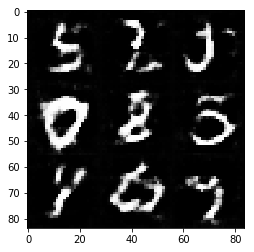

Epochs: 0/2 Discriminator Loss: 1.9479... Generator Loss: 0.2921
Epochs: 0/2 Discriminator Loss: 1.6044... Generator Loss: 0.3943
Epochs: 0/2 Discriminator Loss: 1.7242... Generator Loss: 0.3313
Epochs: 0/2 Discriminator Loss: 1.7102... Generator Loss: 0.3266
Epochs: 0/2 Discriminator Loss: 1.9021... Generator Loss: 0.2881
Epochs: 0/2 Discriminator Loss: 1.7374... Generator Loss: 0.3117
Epochs: 0/2 Discriminator Loss: 1.5796... Generator Loss: 0.3780
Epochs: 0/2 Discriminator Loss: 2.0298... Generator Loss: 0.2428
Epochs: 0/2 Discriminator Loss: 1.3744... Generator Loss: 0.5969
Epochs: 0/2 Discriminator Loss: 1.3936... Generator Loss: 0.5779


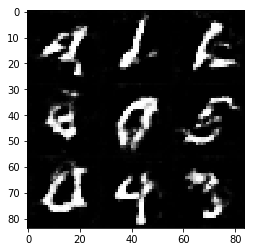

Epochs: 0/2 Discriminator Loss: 2.0117... Generator Loss: 0.2501
Epochs: 0/2 Discriminator Loss: 1.6660... Generator Loss: 0.4199
Epochs: 0/2 Discriminator Loss: 2.2686... Generator Loss: 0.1961
Epochs: 0/2 Discriminator Loss: 1.4105... Generator Loss: 0.4716
Epochs: 0/2 Discriminator Loss: 1.5409... Generator Loss: 0.4166
Epochs: 0/2 Discriminator Loss: 1.6622... Generator Loss: 0.3624
Epochs: 0/2 Discriminator Loss: 1.6675... Generator Loss: 0.3617
Epochs: 0/2 Discriminator Loss: 1.2836... Generator Loss: 0.6079
Epochs: 0/2 Discriminator Loss: 1.7514... Generator Loss: 0.3117
Epochs: 0/2 Discriminator Loss: 1.9914... Generator Loss: 0.2355


Epochs: 0/2 Discriminator Loss: 1.6646... Generator Loss: 0.3598
Epochs: 0/2 Discriminator Loss: 1.4020... Generator Loss: 0.4884
Epochs: 0/2 Discriminator Loss: 1.1500... Generator Loss: 0.7224
Epochs: 0/2 Discriminator Loss: 1.2370... Generator Loss: 0.6857
Epochs: 0/2 Discriminator Loss: 1.5494... Generator Loss: 0.4095
Epochs: 0/2 Discriminator Loss: 1.5961... Generator Loss: 0.3836
Epochs: 0/2 Discriminator Loss: 1.4658... Generator Loss: 0.4577
Epochs: 0/2 Discriminator Loss: 1.4289... Generator Loss: 0.5103
Epochs: 0/2 Discriminator Loss: 1.1438... Generator Loss: 0.9154
Epochs: 0/2 Discriminator Loss: 1.8469... Generator Loss: 0.3305


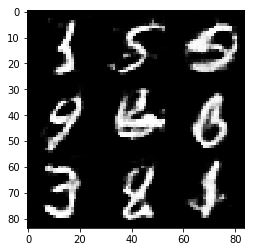

Epochs: 0/2 Discriminator Loss: 1.7302... Generator Loss: 0.3659
Epochs: 0/2 Discriminator Loss: 1.1301... Generator Loss: 1.0004
Epochs: 0/2 Discriminator Loss: 1.5679... Generator Loss: 0.3965
Epochs: 0/2 Discriminator Loss: 1.5091... Generator Loss: 0.4769
Epochs: 0/2 Discriminator Loss: 1.7202... Generator Loss: 0.3530
Epochs: 0/2 Discriminator Loss: 1.6637... Generator Loss: 2.3772
Epochs: 0/2 Discriminator Loss: 1.5620... Generator Loss: 0.3877
Epochs: 0/2 Discriminator Loss: 1.2535... Generator Loss: 0.6384
Epochs: 0/2 Discriminator Loss: 1.4619... Generator Loss: 0.4750
Epochs: 0/2 Discriminator Loss: 1.7748... Generator Loss: 0.3561


Epochs: 0/2 Discriminator Loss: 1.3006... Generator Loss: 0.5529
Epochs: 0/2 Discriminator Loss: 1.4102... Generator Loss: 0.5373
Epochs: 0/2 Discriminator Loss: 1.2350... Generator Loss: 0.7046
Epochs: 0/2 Discriminator Loss: 1.2444... Generator Loss: 1.7570
Epochs: 0/2 Discriminator Loss: 1.2539... Generator Loss: 0.6525
Epochs: 0/2 Discriminator Loss: 1.5120... Generator Loss: 0.4564
Epochs: 0/2 Discriminator Loss: 2.7583... Generator Loss: 0.1436
Epochs: 0/2 Discriminator Loss: 1.5769... Generator Loss: 0.4020
Epochs: 0/2 Discriminator Loss: 2.0143... Generator Loss: 0.2406
Epochs: 0/2 Discriminator Loss: 0.9997... Generator Loss: 1.3267


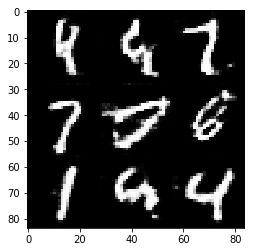

Epochs: 0/2 Discriminator Loss: 1.1610... Generator Loss: 0.7355
Epochs: 0/2 Discriminator Loss: 2.1508... Generator Loss: 0.2108
Epochs: 0/2 Discriminator Loss: 1.0345... Generator Loss: 0.7956
Epochs: 0/2 Discriminator Loss: 0.9657... Generator Loss: 1.3324
Epochs: 0/2 Discriminator Loss: 1.5481... Generator Loss: 0.4159
Epochs: 0/2 Discriminator Loss: 2.5596... Generator Loss: 0.1626
Epochs: 0/2 Discriminator Loss: 1.2282... Generator Loss: 0.6700
Epochs: 0/2 Discriminator Loss: 1.3003... Generator Loss: 0.5811
Epochs: 0/2 Discriminator Loss: 1.7623... Generator Loss: 0.3460
Epochs: 0/2 Discriminator Loss: 1.2014... Generator Loss: 0.7147


Epochs: 0/2 Discriminator Loss: 1.5652... Generator Loss: 0.3918
Epochs: 0/2 Discriminator Loss: 2.2729... Generator Loss: 0.2016
Epochs: 0/2 Discriminator Loss: 1.6724... Generator Loss: 0.3658
Epochs: 1/2 Discriminator Loss: 1.0935... Generator Loss: 0.8422
Epochs: 1/2 Discriminator Loss: 1.3702... Generator Loss: 0.5235
Epochs: 1/2 Discriminator Loss: 1.6735... Generator Loss: 0.3397
Epochs: 1/2 Discriminator Loss: 0.9711... Generator Loss: 0.9880
Epochs: 1/2 Discriminator Loss: 1.0694... Generator Loss: 1.5211
Epochs: 1/2 Discriminator Loss: 1.1960... Generator Loss: 0.7081
Epochs: 1/2 Discriminator Loss: 2.0350... Generator Loss: 0.2444


Epochs: 1/2 Discriminator Loss: 0.9533... Generator Loss: 0.9644
Epochs: 1/2 Discriminator Loss: 1.1179... Generator Loss: 0.7366
Epochs: 1/2 Discriminator Loss: 1.3870... Generator Loss: 0.4926
Epochs: 1/2 Discriminator Loss: 1.7165... Generator Loss: 0.3614
Epochs: 1/2 Discriminator Loss: 2.5252... Generator Loss: 0.1560
Epochs: 1/2 Discriminator Loss: 1.3111... Generator Loss: 0.5787
Epochs: 1/2 Discriminator Loss: 1.7568... Generator Loss: 0.3517
Epochs: 1/2 Discriminator Loss: 0.9406... Generator Loss: 1.0169
Epochs: 1/2 Discriminator Loss: 1.2076... Generator Loss: 1.2054
Epochs: 1/2 Discriminator Loss: 2.1964... Generator Loss: 0.2995


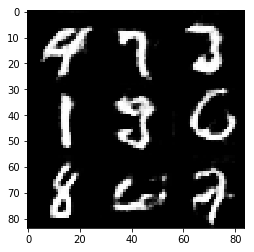

Epochs: 1/2 Discriminator Loss: 1.2527... Generator Loss: 0.6028
Epochs: 1/2 Discriminator Loss: 1.6364... Generator Loss: 0.3692
Epochs: 1/2 Discriminator Loss: 1.5507... Generator Loss: 0.4250
Epochs: 1/2 Discriminator Loss: 2.0525... Generator Loss: 0.2317
Epochs: 1/2 Discriminator Loss: 1.5705... Generator Loss: 0.4447
Epochs: 1/2 Discriminator Loss: 1.5906... Generator Loss: 0.4109
Epochs: 1/2 Discriminator Loss: 1.5021... Generator Loss: 0.4787
Epochs: 1/2 Discriminator Loss: 1.6512... Generator Loss: 0.3686
Epochs: 1/2 Discriminator Loss: 1.3167... Generator Loss: 0.6233
Epochs: 1/2 Discriminator Loss: 1.6353... Generator Loss: 0.4000


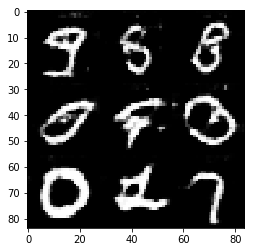

Epochs: 1/2 Discriminator Loss: 1.8951... Generator Loss: 0.3177
Epochs: 1/2 Discriminator Loss: 1.9397... Generator Loss: 0.3710
Epochs: 1/2 Discriminator Loss: 1.1716... Generator Loss: 0.7664
Epochs: 1/2 Discriminator Loss: 1.4847... Generator Loss: 0.4525
Epochs: 1/2 Discriminator Loss: 1.3062... Generator Loss: 0.5879
Epochs: 1/2 Discriminator Loss: 1.5015... Generator Loss: 0.5378
Epochs: 1/2 Discriminator Loss: 1.0994... Generator Loss: 0.8194
Epochs: 1/2 Discriminator Loss: 1.8005... Generator Loss: 0.3025
Epochs: 1/2 Discriminator Loss: 2.0565... Generator Loss: 4.1420
Epochs: 1/2 Discriminator Loss: 1.3006... Generator Loss: 0.5893


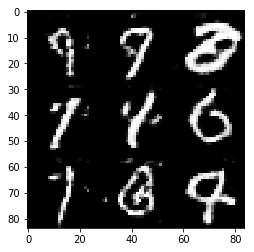

Epochs: 1/2 Discriminator Loss: 1.3190... Generator Loss: 0.5318
Epochs: 1/2 Discriminator Loss: 1.6632... Generator Loss: 2.3641
Epochs: 1/2 Discriminator Loss: 1.6665... Generator Loss: 0.3591
Epochs: 1/2 Discriminator Loss: 1.3674... Generator Loss: 0.5085
Epochs: 1/2 Discriminator Loss: 0.8856... Generator Loss: 1.7357
Epochs: 1/2 Discriminator Loss: 1.6567... Generator Loss: 0.3901
Epochs: 1/2 Discriminator Loss: 0.9933... Generator Loss: 0.8460
Epochs: 1/2 Discriminator Loss: 1.0715... Generator Loss: 0.8627
Epochs: 1/2 Discriminator Loss: 1.4290... Generator Loss: 0.5050
Epochs: 1/2 Discriminator Loss: 1.1896... Generator Loss: 0.6693


Epochs: 1/2 Discriminator Loss: 1.4589... Generator Loss: 0.4803
Epochs: 1/2 Discriminator Loss: 1.1216... Generator Loss: 0.7351
Epochs: 1/2 Discriminator Loss: 1.1898... Generator Loss: 0.6605
Epochs: 1/2 Discriminator Loss: 0.8112... Generator Loss: 1.7172
Epochs: 1/2 Discriminator Loss: 1.3847... Generator Loss: 1.3445
Epochs: 1/2 Discriminator Loss: 1.5791... Generator Loss: 0.4271
Epochs: 1/2 Discriminator Loss: 1.5161... Generator Loss: 0.4433
Epochs: 1/2 Discriminator Loss: 1.4028... Generator Loss: 0.5293
Epochs: 1/2 Discriminator Loss: 2.2623... Generator Loss: 0.1896
Epochs: 1/2 Discriminator Loss: 2.2139... Generator Loss: 0.2428


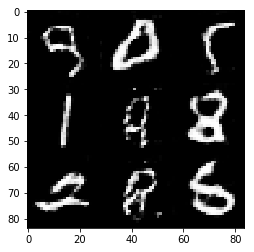

Epochs: 1/2 Discriminator Loss: 1.0038... Generator Loss: 0.8460
Epochs: 1/2 Discriminator Loss: 1.0084... Generator Loss: 1.0628
Epochs: 1/2 Discriminator Loss: 1.2314... Generator Loss: 0.6307
Epochs: 1/2 Discriminator Loss: 0.9803... Generator Loss: 0.8962
Epochs: 1/2 Discriminator Loss: 0.6454... Generator Loss: 1.8364
Epochs: 1/2 Discriminator Loss: 1.7216... Generator Loss: 0.3684
Epochs: 1/2 Discriminator Loss: 1.2737... Generator Loss: 0.5786
Epochs: 1/2 Discriminator Loss: 1.1923... Generator Loss: 0.6270
Epochs: 1/2 Discriminator Loss: 1.7057... Generator Loss: 0.3564
Epochs: 1/2 Discriminator Loss: 1.7140... Generator Loss: 0.3446


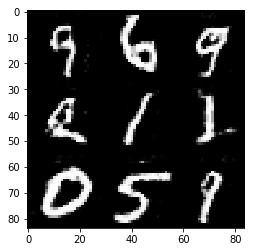

Epochs: 1/2 Discriminator Loss: 2.2614... Generator Loss: 0.2154
Epochs: 1/2 Discriminator Loss: 1.5965... Generator Loss: 0.3973
Epochs: 1/2 Discriminator Loss: 1.1177... Generator Loss: 0.7189
Epochs: 1/2 Discriminator Loss: 2.3303... Generator Loss: 4.5906
Epochs: 1/2 Discriminator Loss: 1.4638... Generator Loss: 0.5673
Epochs: 1/2 Discriminator Loss: 1.1268... Generator Loss: 0.7838
Epochs: 1/2 Discriminator Loss: 0.8434... Generator Loss: 1.1042
Epochs: 1/2 Discriminator Loss: 2.5993... Generator Loss: 0.1878
Epochs: 1/2 Discriminator Loss: 1.4908... Generator Loss: 0.4812
Epochs: 1/2 Discriminator Loss: 0.8415... Generator Loss: 1.6180


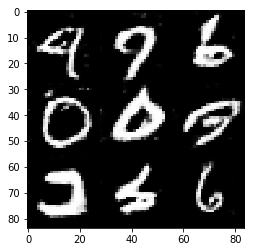

Epochs: 1/2 Discriminator Loss: 1.4418... Generator Loss: 0.5057
Epochs: 1/2 Discriminator Loss: 0.8349... Generator Loss: 1.4543
Epochs: 1/2 Discriminator Loss: 1.8200... Generator Loss: 0.3141
Epochs: 1/2 Discriminator Loss: 1.6635... Generator Loss: 0.3795
Epochs: 1/2 Discriminator Loss: 2.8788... Generator Loss: 2.2073
Epochs: 1/2 Discriminator Loss: 1.7504... Generator Loss: 0.3597
Epochs: 1/2 Discriminator Loss: 1.7684... Generator Loss: 1.3069
Epochs: 1/2 Discriminator Loss: 1.0141... Generator Loss: 0.8512
Epochs: 1/2 Discriminator Loss: 1.9224... Generator Loss: 0.2763
Epochs: 1/2 Discriminator Loss: 0.8584... Generator Loss: 1.2810


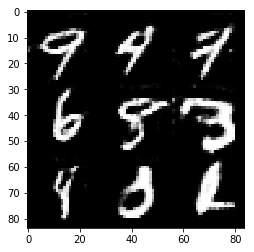

Epochs: 1/2 Discriminator Loss: 1.7387... Generator Loss: 0.3444
Epochs: 1/2 Discriminator Loss: 1.1747... Generator Loss: 0.6926
Epochs: 1/2 Discriminator Loss: 0.9218... Generator Loss: 1.3875
Epochs: 1/2 Discriminator Loss: 0.9734... Generator Loss: 0.8855
Epochs: 1/2 Discriminator Loss: 1.2659... Generator Loss: 0.5846
Epochs: 1/2 Discriminator Loss: 1.2301... Generator Loss: 0.6443
Epochs: 1/2 Discriminator Loss: 1.3063... Generator Loss: 0.5391


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epochs: 0/1 Discriminator Loss: 1.0293... Generator Loss: 1.6020
Epochs: 0/1 Discriminator Loss: 1.3316... Generator Loss: 4.7955
Epochs: 0/1 Discriminator Loss: 1.4238... Generator Loss: 1.2303
Epochs: 0/1 Discriminator Loss: 1.5045... Generator Loss: 0.5557
Epochs: 0/1 Discriminator Loss: 1.5108... Generator Loss: 0.5368
Epochs: 0/1 Discriminator Loss: 1.8656... Generator Loss: 0.3582
Epochs: 0/1 Discriminator Loss: 2.1423... Generator Loss: 0.2741
Epochs: 0/1 Discriminator Loss: 2.4559... Generator Loss: 0.2193
Epochs: 0/1 Discriminator Loss: 1.8408... Generator Loss: 0.3467
Epochs: 0/1 Discriminator Loss: 1.8605... Generator Loss: 0.3528


Epochs: 0/1 Discriminator Loss: 2.2264... Generator Loss: 0.2006
Epochs: 0/1 Discriminator Loss: 1.6404... Generator Loss: 0.3853
Epochs: 0/1 Discriminator Loss: 1.8999... Generator Loss: 0.2887
Epochs: 0/1 Discriminator Loss: 1.8496... Generator Loss: 0.3065
Epochs: 0/1 Discriminator Loss: 1.9095... Generator Loss: 0.2823
Epochs: 0/1 Discriminator Loss: 2.0002... Generator Loss: 0.3022
Epochs: 0/1 Discriminator Loss: 1.6702... Generator Loss: 0.3970
Epochs: 0/1 Discriminator Loss: 1.8083... Generator Loss: 0.3672
Epochs: 0/1 Discriminator Loss: 1.6124... Generator Loss: 0.4537
Epochs: 0/1 Discriminator Loss: 2.0217... Generator Loss: 0.3259


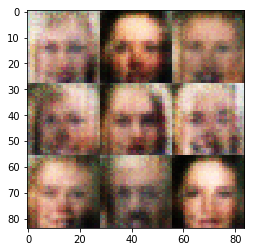

Epochs: 0/1 Discriminator Loss: 1.6705... Generator Loss: 0.3738
Epochs: 0/1 Discriminator Loss: 2.0154... Generator Loss: 0.2623
Epochs: 0/1 Discriminator Loss: 1.6613... Generator Loss: 0.4201
Epochs: 0/1 Discriminator Loss: 1.7964... Generator Loss: 0.3556
Epochs: 0/1 Discriminator Loss: 1.9035... Generator Loss: 0.3359
Epochs: 0/1 Discriminator Loss: 1.6748... Generator Loss: 0.4348
Epochs: 0/1 Discriminator Loss: 1.5439... Generator Loss: 0.4799
Epochs: 0/1 Discriminator Loss: 1.7421... Generator Loss: 0.3610
Epochs: 0/1 Discriminator Loss: 1.6183... Generator Loss: 0.4717
Epochs: 0/1 Discriminator Loss: 1.6343... Generator Loss: 0.4524


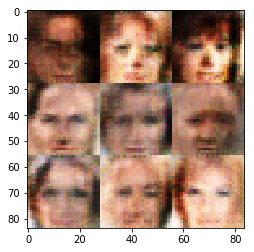

Epochs: 0/1 Discriminator Loss: 1.7607... Generator Loss: 0.4021
Epochs: 0/1 Discriminator Loss: 1.5842... Generator Loss: 0.4796
Epochs: 0/1 Discriminator Loss: 1.5487... Generator Loss: 0.5213
Epochs: 0/1 Discriminator Loss: 1.6559... Generator Loss: 0.4593
Epochs: 0/1 Discriminator Loss: 1.5749... Generator Loss: 0.4474
Epochs: 0/1 Discriminator Loss: 1.6529... Generator Loss: 0.4184
Epochs: 0/1 Discriminator Loss: 1.5800... Generator Loss: 0.4589
Epochs: 0/1 Discriminator Loss: 1.4676... Generator Loss: 0.5824
Epochs: 0/1 Discriminator Loss: 1.5558... Generator Loss: 0.4820
Epochs: 0/1 Discriminator Loss: 1.6356... Generator Loss: 0.4350


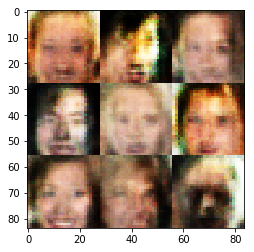

Epochs: 0/1 Discriminator Loss: 1.5851... Generator Loss: 0.4366
Epochs: 0/1 Discriminator Loss: 1.4588... Generator Loss: 0.5635
Epochs: 0/1 Discriminator Loss: 1.5766... Generator Loss: 0.4619
Epochs: 0/1 Discriminator Loss: 1.5030... Generator Loss: 0.4961
Epochs: 0/1 Discriminator Loss: 1.4618... Generator Loss: 0.5354
Epochs: 0/1 Discriminator Loss: 1.5784... Generator Loss: 0.4361
Epochs: 0/1 Discriminator Loss: 1.6607... Generator Loss: 0.3994
Epochs: 0/1 Discriminator Loss: 1.6478... Generator Loss: 0.4198
Epochs: 0/1 Discriminator Loss: 1.6797... Generator Loss: 0.4249
Epochs: 0/1 Discriminator Loss: 1.4441... Generator Loss: 0.5180


Epochs: 0/1 Discriminator Loss: 1.5817... Generator Loss: 0.4730
Epochs: 0/1 Discriminator Loss: 1.5737... Generator Loss: 0.4581
Epochs: 0/1 Discriminator Loss: 1.6788... Generator Loss: 0.3866
Epochs: 0/1 Discriminator Loss: 1.5704... Generator Loss: 0.4842
Epochs: 0/1 Discriminator Loss: 1.5840... Generator Loss: 0.5032
Epochs: 0/1 Discriminator Loss: 1.6386... Generator Loss: 0.4671
Epochs: 0/1 Discriminator Loss: 1.6743... Generator Loss: 0.4213
Epochs: 0/1 Discriminator Loss: 1.5350... Generator Loss: 0.4641
Epochs: 0/1 Discriminator Loss: 1.4966... Generator Loss: 0.5162
Epochs: 0/1 Discriminator Loss: 1.6970... Generator Loss: 0.3880


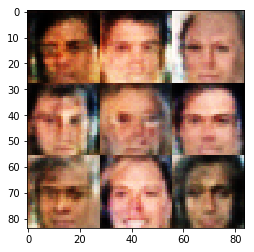

Epochs: 0/1 Discriminator Loss: 1.7678... Generator Loss: 0.3756
Epochs: 0/1 Discriminator Loss: 1.7323... Generator Loss: 0.3581
Epochs: 0/1 Discriminator Loss: 1.6565... Generator Loss: 0.4132
Epochs: 0/1 Discriminator Loss: 1.6009... Generator Loss: 0.4253
Epochs: 0/1 Discriminator Loss: 1.5738... Generator Loss: 0.4467
Epochs: 0/1 Discriminator Loss: 1.7053... Generator Loss: 0.3794
Epochs: 0/1 Discriminator Loss: 1.6314... Generator Loss: 0.4212
Epochs: 0/1 Discriminator Loss: 1.5704... Generator Loss: 0.4513
Epochs: 0/1 Discriminator Loss: 1.8244... Generator Loss: 0.3278
Epochs: 0/1 Discriminator Loss: 1.7510... Generator Loss: 0.3488


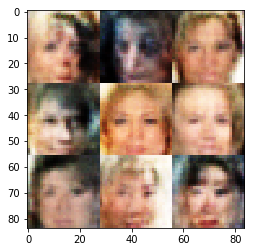

Epochs: 0/1 Discriminator Loss: 1.5761... Generator Loss: 0.4540
Epochs: 0/1 Discriminator Loss: 1.5927... Generator Loss: 0.4720
Epochs: 0/1 Discriminator Loss: 1.6377... Generator Loss: 0.3931
Epochs: 0/1 Discriminator Loss: 1.5950... Generator Loss: 0.4350
Epochs: 0/1 Discriminator Loss: 1.7404... Generator Loss: 0.3775
Epochs: 0/1 Discriminator Loss: 1.6027... Generator Loss: 0.4241
Epochs: 0/1 Discriminator Loss: 1.7075... Generator Loss: 0.3891
Epochs: 0/1 Discriminator Loss: 1.9190... Generator Loss: 0.2864
Epochs: 0/1 Discriminator Loss: 1.6570... Generator Loss: 0.4317
Epochs: 0/1 Discriminator Loss: 1.6362... Generator Loss: 0.4348


Epochs: 0/1 Discriminator Loss: 1.6122... Generator Loss: 0.4363
Epochs: 0/1 Discriminator Loss: 1.6414... Generator Loss: 0.4237
Epochs: 0/1 Discriminator Loss: 1.5679... Generator Loss: 0.4558
Epochs: 0/1 Discriminator Loss: 1.6612... Generator Loss: 0.4203
Epochs: 0/1 Discriminator Loss: 1.8417... Generator Loss: 0.3477
Epochs: 0/1 Discriminator Loss: 1.6819... Generator Loss: 0.3897
Epochs: 0/1 Discriminator Loss: 1.7129... Generator Loss: 0.3959
Epochs: 0/1 Discriminator Loss: 1.8457... Generator Loss: 0.3074
Epochs: 0/1 Discriminator Loss: 1.7415... Generator Loss: 0.3550
Epochs: 0/1 Discriminator Loss: 1.6485... Generator Loss: 0.4205


Epochs: 0/1 Discriminator Loss: 1.8255... Generator Loss: 0.3355
Epochs: 0/1 Discriminator Loss: 1.6509... Generator Loss: 0.4053
Epochs: 0/1 Discriminator Loss: 1.7381... Generator Loss: 0.3599
Epochs: 0/1 Discriminator Loss: 1.8598... Generator Loss: 0.3494
Epochs: 0/1 Discriminator Loss: 1.6537... Generator Loss: 0.4211
Epochs: 0/1 Discriminator Loss: 1.7060... Generator Loss: 0.3797
Epochs: 0/1 Discriminator Loss: 1.6984... Generator Loss: 0.3695
Epochs: 0/1 Discriminator Loss: 1.6879... Generator Loss: 0.3996
Epochs: 0/1 Discriminator Loss: 1.9454... Generator Loss: 0.2942
Epochs: 0/1 Discriminator Loss: 1.7458... Generator Loss: 0.3812


Epochs: 0/1 Discriminator Loss: 1.5827... Generator Loss: 0.4847
Epochs: 0/1 Discriminator Loss: 1.8275... Generator Loss: 0.3295
Epochs: 0/1 Discriminator Loss: 1.7555... Generator Loss: 0.3387
Epochs: 0/1 Discriminator Loss: 1.6587... Generator Loss: 0.3821
Epochs: 0/1 Discriminator Loss: 1.7593... Generator Loss: 0.3526
Epochs: 0/1 Discriminator Loss: 1.8111... Generator Loss: 0.3774
Epochs: 0/1 Discriminator Loss: 1.7420... Generator Loss: 0.3777
Epochs: 0/1 Discriminator Loss: 1.7455... Generator Loss: 0.3697
Epochs: 0/1 Discriminator Loss: 1.6366... Generator Loss: 0.4190
Epochs: 0/1 Discriminator Loss: 1.6701... Generator Loss: 0.4131


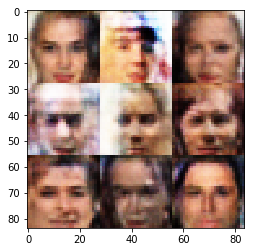

Epochs: 0/1 Discriminator Loss: 1.6125... Generator Loss: 0.4128
Epochs: 0/1 Discriminator Loss: 1.7595... Generator Loss: 0.3474
Epochs: 0/1 Discriminator Loss: 1.5292... Generator Loss: 0.4475
Epochs: 0/1 Discriminator Loss: 1.7795... Generator Loss: 0.3656
Epochs: 0/1 Discriminator Loss: 1.8427... Generator Loss: 0.3219
Epochs: 0/1 Discriminator Loss: 1.5717... Generator Loss: 0.4945
Epochs: 0/1 Discriminator Loss: 1.5616... Generator Loss: 0.4248
Epochs: 0/1 Discriminator Loss: 1.8512... Generator Loss: 0.3129
Epochs: 0/1 Discriminator Loss: 2.1604... Generator Loss: 0.2265
Epochs: 0/1 Discriminator Loss: 1.7808... Generator Loss: 0.3350


Epochs: 0/1 Discriminator Loss: 1.8365... Generator Loss: 0.3191
Epochs: 0/1 Discriminator Loss: 1.7498... Generator Loss: 0.3216
Epochs: 0/1 Discriminator Loss: 1.7515... Generator Loss: 0.3696
Epochs: 0/1 Discriminator Loss: 1.7287... Generator Loss: 0.3666
Epochs: 0/1 Discriminator Loss: 1.5778... Generator Loss: 0.4314
Epochs: 0/1 Discriminator Loss: 1.8174... Generator Loss: 0.3378
Epochs: 0/1 Discriminator Loss: 1.6258... Generator Loss: 0.3943
Epochs: 0/1 Discriminator Loss: 1.7921... Generator Loss: 0.3400
Epochs: 0/1 Discriminator Loss: 1.9713... Generator Loss: 0.2769
Epochs: 0/1 Discriminator Loss: 1.5243... Generator Loss: 0.4622


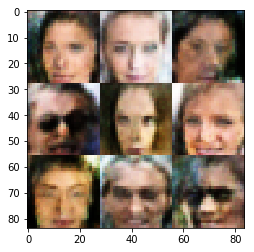

Epochs: 0/1 Discriminator Loss: 1.6603... Generator Loss: 0.4097
Epochs: 0/1 Discriminator Loss: 1.6795... Generator Loss: 0.3865
Epochs: 0/1 Discriminator Loss: 1.7484... Generator Loss: 0.3630
Epochs: 0/1 Discriminator Loss: 2.0048... Generator Loss: 0.2383
Epochs: 0/1 Discriminator Loss: 1.5897... Generator Loss: 0.4303
Epochs: 0/1 Discriminator Loss: 1.6493... Generator Loss: 0.4105
Epochs: 0/1 Discriminator Loss: 1.5642... Generator Loss: 0.4541
Epochs: 0/1 Discriminator Loss: 1.8357... Generator Loss: 0.3192
Epochs: 0/1 Discriminator Loss: 1.5552... Generator Loss: 0.4773
Epochs: 0/1 Discriminator Loss: 1.7739... Generator Loss: 0.3726


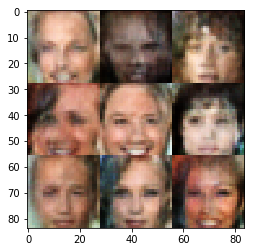

Epochs: 0/1 Discriminator Loss: 1.9145... Generator Loss: 0.2731
Epochs: 0/1 Discriminator Loss: 1.7084... Generator Loss: 0.3475
Epochs: 0/1 Discriminator Loss: 1.9154... Generator Loss: 0.2794
Epochs: 0/1 Discriminator Loss: 1.7851... Generator Loss: 0.3379
Epochs: 0/1 Discriminator Loss: 1.8987... Generator Loss: 0.2934
Epochs: 0/1 Discriminator Loss: 2.0849... Generator Loss: 0.2425
Epochs: 0/1 Discriminator Loss: 1.7201... Generator Loss: 0.3634
Epochs: 0/1 Discriminator Loss: 1.7556... Generator Loss: 0.3417
Epochs: 0/1 Discriminator Loss: 1.7711... Generator Loss: 0.3536
Epochs: 0/1 Discriminator Loss: 1.8062... Generator Loss: 0.3376


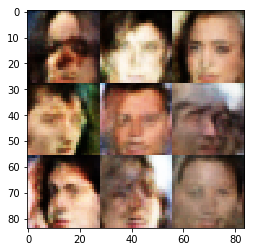

Epochs: 0/1 Discriminator Loss: 1.9419... Generator Loss: 0.2739
Epochs: 0/1 Discriminator Loss: 1.9626... Generator Loss: 0.2574
Epochs: 0/1 Discriminator Loss: 1.5702... Generator Loss: 0.4375
Epochs: 0/1 Discriminator Loss: 1.7322... Generator Loss: 0.3422
Epochs: 0/1 Discriminator Loss: 1.6678... Generator Loss: 0.4000
Epochs: 0/1 Discriminator Loss: 1.8397... Generator Loss: 0.3220
Epochs: 0/1 Discriminator Loss: 1.7068... Generator Loss: 0.3632
Epochs: 0/1 Discriminator Loss: 1.6964... Generator Loss: 0.3700
Epochs: 0/1 Discriminator Loss: 2.0758... Generator Loss: 0.2441
Epochs: 0/1 Discriminator Loss: 1.6352... Generator Loss: 0.3827


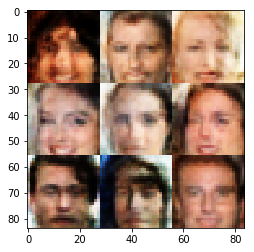

Epochs: 0/1 Discriminator Loss: 1.5403... Generator Loss: 0.4628
Epochs: 0/1 Discriminator Loss: 1.7719... Generator Loss: 0.3204
Epochs: 0/1 Discriminator Loss: 1.8090... Generator Loss: 0.3066
Epochs: 0/1 Discriminator Loss: 1.8636... Generator Loss: 0.2937
Epochs: 0/1 Discriminator Loss: 1.8283... Generator Loss: 0.3051
Epochs: 0/1 Discriminator Loss: 1.8862... Generator Loss: 0.3006
Epochs: 0/1 Discriminator Loss: 1.8855... Generator Loss: 0.3111
Epochs: 0/1 Discriminator Loss: 1.7431... Generator Loss: 0.3570
Epochs: 0/1 Discriminator Loss: 1.7885... Generator Loss: 0.3212
Epochs: 0/1 Discriminator Loss: 2.1611... Generator Loss: 0.2298


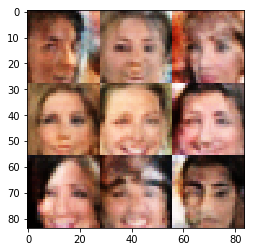

Epochs: 0/1 Discriminator Loss: 1.8092... Generator Loss: 0.3266
Epochs: 0/1 Discriminator Loss: 1.5805... Generator Loss: 0.4098
Epochs: 0/1 Discriminator Loss: 1.9489... Generator Loss: 0.2689
Epochs: 0/1 Discriminator Loss: 1.7589... Generator Loss: 0.3531
Epochs: 0/1 Discriminator Loss: 1.8343... Generator Loss: 0.3140
Epochs: 0/1 Discriminator Loss: 1.8455... Generator Loss: 0.3375
Epochs: 0/1 Discriminator Loss: 1.8471... Generator Loss: 0.2882
Epochs: 0/1 Discriminator Loss: 1.6645... Generator Loss: 0.4008
Epochs: 0/1 Discriminator Loss: 1.6621... Generator Loss: 0.3761
Epochs: 0/1 Discriminator Loss: 1.7233... Generator Loss: 0.3908


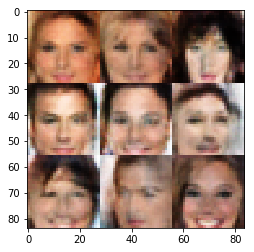

Epochs: 0/1 Discriminator Loss: 1.7711... Generator Loss: 0.3406
Epochs: 0/1 Discriminator Loss: 1.8413... Generator Loss: 0.3043
Epochs: 0/1 Discriminator Loss: 1.7805... Generator Loss: 0.3230
Epochs: 0/1 Discriminator Loss: 1.9401... Generator Loss: 0.2765
Epochs: 0/1 Discriminator Loss: 1.6796... Generator Loss: 0.3703
Epochs: 0/1 Discriminator Loss: 1.7341... Generator Loss: 0.3905
Epochs: 0/1 Discriminator Loss: 1.8875... Generator Loss: 0.2804
Epochs: 0/1 Discriminator Loss: 1.8434... Generator Loss: 0.3192
Epochs: 0/1 Discriminator Loss: 2.0780... Generator Loss: 0.2539
Epochs: 0/1 Discriminator Loss: 1.9259... Generator Loss: 0.2873


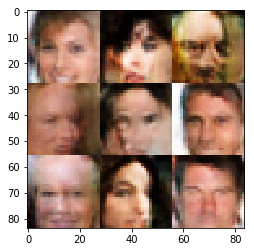

Epochs: 0/1 Discriminator Loss: 1.7986... Generator Loss: 0.3306
Epochs: 0/1 Discriminator Loss: 1.7731... Generator Loss: 0.3328
Epochs: 0/1 Discriminator Loss: 2.0511... Generator Loss: 0.2375
Epochs: 0/1 Discriminator Loss: 1.8595... Generator Loss: 0.2935
Epochs: 0/1 Discriminator Loss: 1.8136... Generator Loss: 0.3169
Epochs: 0/1 Discriminator Loss: 1.9077... Generator Loss: 0.3181
Epochs: 0/1 Discriminator Loss: 1.6848... Generator Loss: 0.3500
Epochs: 0/1 Discriminator Loss: 1.8334... Generator Loss: 0.3191
Epochs: 0/1 Discriminator Loss: 1.8832... Generator Loss: 0.2891
Epochs: 0/1 Discriminator Loss: 1.8876... Generator Loss: 0.2874


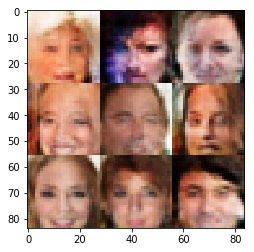

Epochs: 0/1 Discriminator Loss: 1.6260... Generator Loss: 0.3949
Epochs: 0/1 Discriminator Loss: 1.8578... Generator Loss: 0.2818
Epochs: 0/1 Discriminator Loss: 1.7300... Generator Loss: 0.3605
Epochs: 0/1 Discriminator Loss: 2.0283... Generator Loss: 0.2590
Epochs: 0/1 Discriminator Loss: 1.8496... Generator Loss: 0.2938
Epochs: 0/1 Discriminator Loss: 1.7884... Generator Loss: 0.3442
Epochs: 0/1 Discriminator Loss: 1.8896... Generator Loss: 0.2710
Epochs: 0/1 Discriminator Loss: 1.7860... Generator Loss: 0.3376
Epochs: 0/1 Discriminator Loss: 1.8404... Generator Loss: 0.3104
Epochs: 0/1 Discriminator Loss: 1.7956... Generator Loss: 0.3127


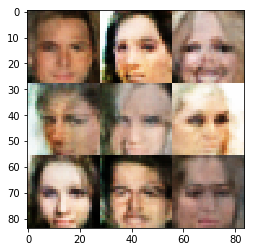

Epochs: 0/1 Discriminator Loss: 1.9853... Generator Loss: 0.2711
Epochs: 0/1 Discriminator Loss: 1.8319... Generator Loss: 0.2808
Epochs: 0/1 Discriminator Loss: 1.8520... Generator Loss: 0.2981
Epochs: 0/1 Discriminator Loss: 1.8396... Generator Loss: 0.3157
Epochs: 0/1 Discriminator Loss: 2.0410... Generator Loss: 0.2698
Epochs: 0/1 Discriminator Loss: 1.8743... Generator Loss: 0.2855
Epochs: 0/1 Discriminator Loss: 1.6330... Generator Loss: 0.4048
Epochs: 0/1 Discriminator Loss: 1.7480... Generator Loss: 0.3407
Epochs: 0/1 Discriminator Loss: 1.6581... Generator Loss: 0.3781
Epochs: 0/1 Discriminator Loss: 1.8478... Generator Loss: 0.3021


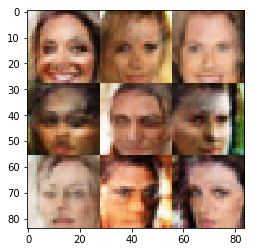

Epochs: 0/1 Discriminator Loss: 1.8630... Generator Loss: 0.3039
Epochs: 0/1 Discriminator Loss: 1.9583... Generator Loss: 0.2689
Epochs: 0/1 Discriminator Loss: 1.9111... Generator Loss: 0.2897
Epochs: 0/1 Discriminator Loss: 1.8455... Generator Loss: 0.3152
Epochs: 0/1 Discriminator Loss: 1.8046... Generator Loss: 0.3341
Epochs: 0/1 Discriminator Loss: 1.8318... Generator Loss: 0.3251
Epochs: 0/1 Discriminator Loss: 1.8687... Generator Loss: 0.2993
Epochs: 0/1 Discriminator Loss: 1.6295... Generator Loss: 0.3847
Epochs: 0/1 Discriminator Loss: 1.7460... Generator Loss: 0.3446
Epochs: 0/1 Discriminator Loss: 1.8345... Generator Loss: 0.3082


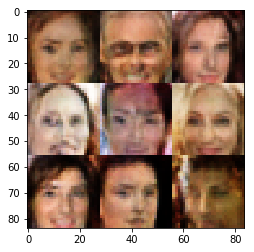

Epochs: 0/1 Discriminator Loss: 1.9163... Generator Loss: 0.2808
Epochs: 0/1 Discriminator Loss: 2.0164... Generator Loss: 0.2402
Epochs: 0/1 Discriminator Loss: 1.8253... Generator Loss: 0.3060
Epochs: 0/1 Discriminator Loss: 1.7683... Generator Loss: 0.3466
Epochs: 0/1 Discriminator Loss: 1.7224... Generator Loss: 0.3646
Epochs: 0/1 Discriminator Loss: 1.7100... Generator Loss: 0.3485
Epochs: 0/1 Discriminator Loss: 1.8403... Generator Loss: 0.2894
Epochs: 0/1 Discriminator Loss: 1.8415... Generator Loss: 0.3046
Epochs: 0/1 Discriminator Loss: 1.8469... Generator Loss: 0.2861
Epochs: 0/1 Discriminator Loss: 2.0236... Generator Loss: 0.2420


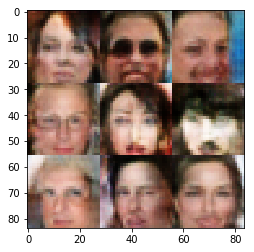

Epochs: 0/1 Discriminator Loss: 1.6640... Generator Loss: 0.3805
Epochs: 0/1 Discriminator Loss: 1.8425... Generator Loss: 0.3176
Epochs: 0/1 Discriminator Loss: 1.8157... Generator Loss: 0.2998
Epochs: 0/1 Discriminator Loss: 1.8432... Generator Loss: 0.3168
Epochs: 0/1 Discriminator Loss: 2.0706... Generator Loss: 0.2353
Epochs: 0/1 Discriminator Loss: 1.7148... Generator Loss: 0.3681
Epochs: 0/1 Discriminator Loss: 1.9706... Generator Loss: 0.2525
Epochs: 0/1 Discriminator Loss: 1.7873... Generator Loss: 0.3294
Epochs: 0/1 Discriminator Loss: 2.0137... Generator Loss: 0.2550
Epochs: 0/1 Discriminator Loss: 2.2152... Generator Loss: 0.1941


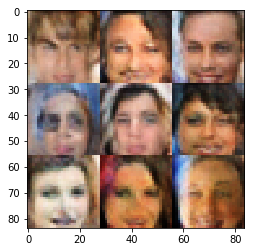

Epochs: 0/1 Discriminator Loss: 1.7989... Generator Loss: 0.3350
Epochs: 0/1 Discriminator Loss: 2.1858... Generator Loss: 0.2276
Epochs: 0/1 Discriminator Loss: 1.7863... Generator Loss: 0.3080
Epochs: 0/1 Discriminator Loss: 1.7854... Generator Loss: 0.3051
Epochs: 0/1 Discriminator Loss: 1.9753... Generator Loss: 0.2589
Epochs: 0/1 Discriminator Loss: 2.1419... Generator Loss: 0.2395
Epochs: 0/1 Discriminator Loss: 1.8597... Generator Loss: 0.3154
Epochs: 0/1 Discriminator Loss: 1.9264... Generator Loss: 0.2633
Epochs: 0/1 Discriminator Loss: 2.0026... Generator Loss: 0.2729
Epochs: 0/1 Discriminator Loss: 1.9592... Generator Loss: 0.2627


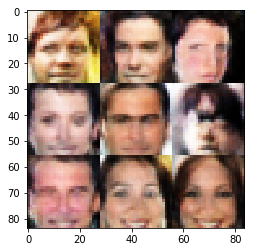

Epochs: 0/1 Discriminator Loss: 1.7128... Generator Loss: 0.3634
Epochs: 0/1 Discriminator Loss: 1.9175... Generator Loss: 0.2875
Epochs: 0/1 Discriminator Loss: 1.9460... Generator Loss: 0.2720
Epochs: 0/1 Discriminator Loss: 1.9370... Generator Loss: 0.2574
Epochs: 0/1 Discriminator Loss: 1.7200... Generator Loss: 0.3688
Epochs: 0/1 Discriminator Loss: 1.6832... Generator Loss: 0.3670
Epochs: 0/1 Discriminator Loss: 1.9506... Generator Loss: 0.2698
Epochs: 0/1 Discriminator Loss: 1.8882... Generator Loss: 0.2722
Epochs: 0/1 Discriminator Loss: 1.7513... Generator Loss: 0.3442
Epochs: 0/1 Discriminator Loss: 1.6847... Generator Loss: 0.3387


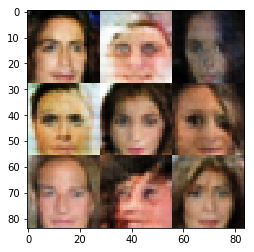

Epochs: 0/1 Discriminator Loss: 1.8401... Generator Loss: 0.3299
Epochs: 0/1 Discriminator Loss: 1.9393... Generator Loss: 0.2419
Epochs: 0/1 Discriminator Loss: 2.1609... Generator Loss: 0.2061
Epochs: 0/1 Discriminator Loss: 1.6161... Generator Loss: 0.4065
Epochs: 0/1 Discriminator Loss: 1.7744... Generator Loss: 0.3090
Epochs: 0/1 Discriminator Loss: 1.8430... Generator Loss: 0.2988
Epochs: 0/1 Discriminator Loss: 1.9673... Generator Loss: 0.2656
Epochs: 0/1 Discriminator Loss: 1.5854... Generator Loss: 0.4018
Epochs: 0/1 Discriminator Loss: 1.9637... Generator Loss: 0.2541
Epochs: 0/1 Discriminator Loss: 1.7022... Generator Loss: 0.3536


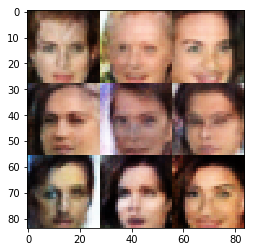

Epochs: 0/1 Discriminator Loss: 1.8830... Generator Loss: 0.2887
Epochs: 0/1 Discriminator Loss: 2.0107... Generator Loss: 0.2448
Epochs: 0/1 Discriminator Loss: 1.6333... Generator Loss: 0.3981
Epochs: 0/1 Discriminator Loss: 1.8215... Generator Loss: 0.3137
Epochs: 0/1 Discriminator Loss: 1.9564... Generator Loss: 0.2670
Epochs: 0/1 Discriminator Loss: 2.0293... Generator Loss: 0.2366
Epochs: 0/1 Discriminator Loss: 1.9657... Generator Loss: 0.2483
Epochs: 0/1 Discriminator Loss: 1.9133... Generator Loss: 0.2737
Epochs: 0/1 Discriminator Loss: 1.8961... Generator Loss: 0.2767
Epochs: 0/1 Discriminator Loss: 1.7715... Generator Loss: 0.3287


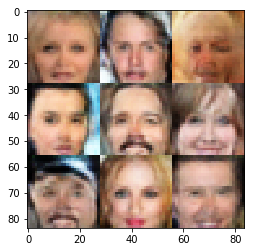

Epochs: 0/1 Discriminator Loss: 1.8985... Generator Loss: 0.2702
Epochs: 0/1 Discriminator Loss: 1.9132... Generator Loss: 0.2753
Epochs: 0/1 Discriminator Loss: 1.9562... Generator Loss: 0.2513
Epochs: 0/1 Discriminator Loss: 1.8443... Generator Loss: 0.3095
Epochs: 0/1 Discriminator Loss: 1.8926... Generator Loss: 0.3114
Epochs: 0/1 Discriminator Loss: 2.1154... Generator Loss: 0.2201
Epochs: 0/1 Discriminator Loss: 2.0652... Generator Loss: 0.2233
Epochs: 0/1 Discriminator Loss: 2.0242... Generator Loss: 0.2808
Epochs: 0/1 Discriminator Loss: 2.0943... Generator Loss: 0.2260
Epochs: 0/1 Discriminator Loss: 1.8066... Generator Loss: 0.3213


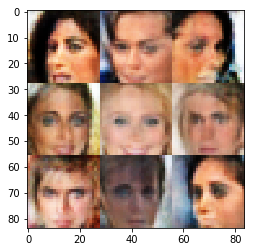

Epochs: 0/1 Discriminator Loss: 1.7536... Generator Loss: 0.3187
Epochs: 0/1 Discriminator Loss: 1.9269... Generator Loss: 0.2706
Epochs: 0/1 Discriminator Loss: 1.9433... Generator Loss: 0.2479
Epochs: 0/1 Discriminator Loss: 1.8099... Generator Loss: 0.3000
Epochs: 0/1 Discriminator Loss: 1.6824... Generator Loss: 0.3708
Epochs: 0/1 Discriminator Loss: 1.8537... Generator Loss: 0.3080
Epochs: 0/1 Discriminator Loss: 1.8620... Generator Loss: 0.2817
Epochs: 0/1 Discriminator Loss: 1.7205... Generator Loss: 0.3295
Epochs: 0/1 Discriminator Loss: 2.0476... Generator Loss: 0.2389
Epochs: 0/1 Discriminator Loss: 2.0828... Generator Loss: 0.2180


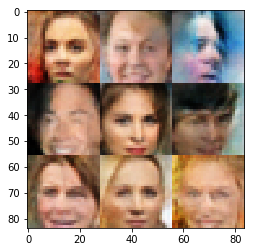

Epochs: 0/1 Discriminator Loss: 2.0347... Generator Loss: 0.2391
Epochs: 0/1 Discriminator Loss: 1.8676... Generator Loss: 0.2858
Epochs: 0/1 Discriminator Loss: 1.9461... Generator Loss: 0.2701
Epochs: 0/1 Discriminator Loss: 1.8227... Generator Loss: 0.2951
Epochs: 0/1 Discriminator Loss: 1.6536... Generator Loss: 0.3625
Epochs: 0/1 Discriminator Loss: 1.9257... Generator Loss: 0.2681


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.